In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import metrics
import requests, os
from zipfile import ZipFile
import shutil
from sklearn.cluster import MiniBatchKMeans 
import copy
from sklearn import svm as SVM
from sklearn.metrics import roc_curve, roc_auc_score, auc

2022-12-07 13:06:59.886498: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-07 13:07:00.451323: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/vscode/.local/lib/python3.10/site-packages/cv2/../../lib64:
2022-12-07 13:07:00.451384: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-07 13:07:01.556866: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerr

Consts

In [2]:
ZIP_PATH = "http://people.csail.mit.edu/torralba/code/spatialenvelope/spatial_envelope_256x256_static_8outdoorcategories.zip"
filename = ZIP_PATH.split("/")[-1]
foldername = filename.split(".")[0]
images_folder='images'
SIZE_OF_HIST = 8
k = 100
FIRST_LABEL = 'forest'
SECOND_LABEL = 'mountain'

Helper Functions

In [3]:
'''
Download and unzip file
'''
def load_files():    
    with open(filename, "wb") as f:
        r = requests.get(ZIP_PATH)
        f.write(r.content)
    with ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall()
        nameList = zip_ref.namelist()
        imgs = [name.split("/")[-1] for name in nameList if name.endswith('.jpg')]
        forest_images = [name for name in imgs if name.startswith(FIRST_LABEL+'_')]
        mountain_images = [name for name in imgs if name.startswith(SECOND_LABEL+'_')]
    shutil.move(foldername, images_folder)
    return forest_images,mountain_images


In [4]:
def prepare_set(image_names, precent):
    num_imgs = len(image_names)
    split_index = int(num_imgs*precent)
    train_set = image_names[:split_index-1]
    test_set = image_names[split_index:]
    return train_set, test_set

In [5]:
def get_image_by_name(filename):
    filename = images_folder+'//' + filename
    image = cv2.imread(filename)
    return image


In [6]:
def convert_image_to_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

1. Compute dense SIFT from the images

In [7]:
def get_danse_SIFT(filename):
    image = get_image_by_name(filename)
    gray_image = convert_image_to_gray(image)
    sift = cv2.SIFT_create()
    key_point = [cv2.KeyPoint(x, y, SIZE_OF_HIST) for x in range(0, gray_image.shape[0], SIZE_OF_HIST) for y in range(0, gray_image.shape[1], SIZE_OF_HIST)]
    dense_shift = sift.compute(image, key_point)[1]
    return dense_shift.astype(float) 

In [8]:
def get_all_hists(x_train):
    all_hists = []
    for elm in x_train:
        dense_sift = get_danse_SIFT(elm)
        for c in dense_sift:
            all_hists.append(c)
    return np.array(all_hists)

In [9]:
def calculate_kmeans(all_train_desc, k):
    kmeans = MiniBatchKMeans (n_clusters=k, random_state=0, batch_size=1000, max_iter=100000)
    kmeans.fit(all_train_desc)
    return kmeans

In [10]:
def get_numeric(name):
    if name == FIRST_LABEL:
        return 0
    elif name == SECOND_LABEL:
        return 1
    else:
        return -1

In [11]:
# form training set histograms for each training image using BoW representation
def calculate_histogram(x_train, kmeans, k):
    hist_set = []
    set_y = []
    for elm in x_train:
        predict = kmeans.predict(get_danse_SIFT(elm))
        hist, _ = np.histogram(predict, bins=np.arange(100), density=True)
        hist_set.append(np.asarray(hist))
        set_y.append(get_numeric(elm.split('_')[0]))     
    return np.array(hist_set), np.array(set_y)

In [12]:
def train_svm(x, y, c):
    # Train an SVM classifier
    svm = SVM.SVC(C=c, cache_size=4000, probability=True)
    svm.fit(x, y)    
    return svm

In [13]:
def create_train_test_sets(precent=0.8):
    images_set1,images_set2 = load_files()
    train_set_1, test_set_1 = prepare_set(images_set1, precent)
    train_set_2, test_set_2 = prepare_set(images_set2, precent)
    train_set = train_set_1+train_set_2
    test_set = test_set_1+test_set_2
    return train_set, test_set

In [14]:
train_set, test_set = create_train_test_sets()
all_hists_x = get_all_hists(train_set)
kmeans = calculate_kmeans(all_hists_x, k)
train_x, train_y  = calculate_histogram(train_set, kmeans, k)
test_x, test_y = calculate_histogram(test_set, kmeans, k)

In [15]:
def svm_bow(train_x, train_y, test_x, test_y, C=10.0, k=100):
    svm = train_svm(train_x,train_y, C)
    predict = svm.predict(test_x)
    return predict, metrics.roc_auc_score(predict, test_y) * k, svm
   

In [16]:
_, accuracy, _ = svm_bow(train_x, train_y, test_x, test_y)
print("the Prediction Accuracy Score is: " + str(accuracy))

the Prediction Accuracy Score is: 95.72727272727273


the Prediction Accuracy Score is: 94.58962841976319


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

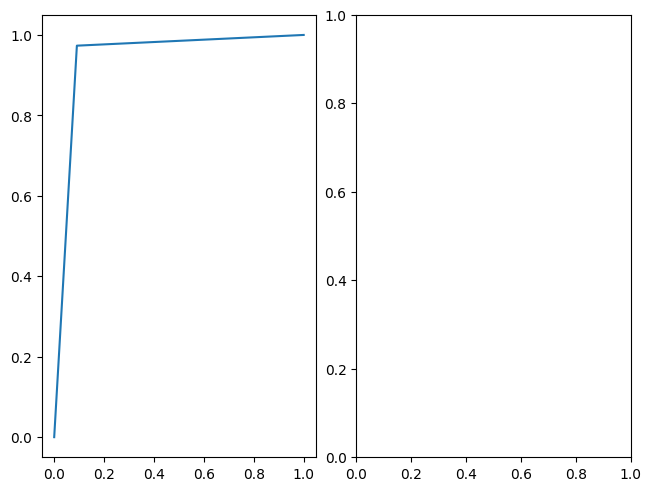

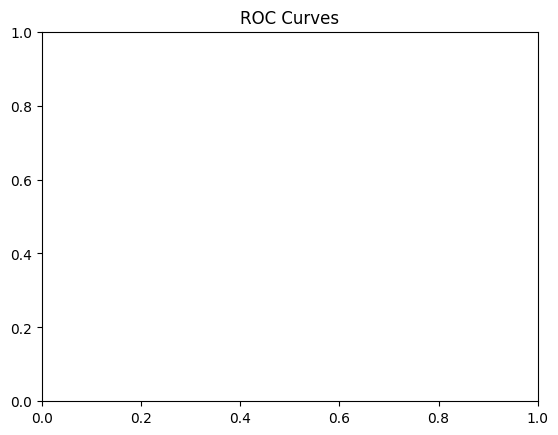

In [19]:
import scikitplot as skplt
c_params = [0.05, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
accuracies = []
figure, (predictionScorePlot, rocPlot) = plt.subplots(1,2, constrained_layout=True)
for c in c_params:
    predict, accuracy, svm = svm_bow(train_x, train_y, test_x, test_y, C=c)
    print("the Prediction Accuracy Score is: " + str(accuracy))
    accuracies.append(accuracy)
    # 
    false_positive_rate, true_positive_rate, threshold = roc_curve(test_y, predict)
    predictionScorePlot.plot(false_positive_rate, true_positive_rate)
    plot = skplt.metrics.plot_roc(predict, test_y)
plt.title("ROC Curves - K-Nearest Neighbors")
plt.show()
# sets the x,y labels and title of ROC curve and plot it
rocPlot.set_title('ROC curve ')

#rocPlot.show()
predictionScorePlot.set_title('prediction score by C = ' + str(c_params))
predictionScorePlot.plot(accuracies)
# displays the figure
plt.show()

In [ ]:
shutil.rmtree(foldername, ignore_errors=True)
shutil.rmtree(images_folder, ignore_errors=True)
os.remove(filename)

TypeError: 'ignore_errors' is an invalid keyword argument for remove()